## Decision Tree Modelling

#### Using a decision tree, we can predict a citizen's perception of Chinese Influence 

The following modeling allows for manipulation of class labels, categorical or binary responses, and decision tree depth. This is an experimental model and should not be counted as fully deterministic. 

## Goal: Identify explanatory models for Chinese Influence

Source: 2019 Pew Data 
Models: Logisitic/Linear Regression, Random Forests, SVM

__Random Forest:__
- goal: predictive personality typing of those prone to influence / favorabiity toward China
- See 2019_RF_Modeling

__Regression:__
- goal: extent of influence globally
- dependant variables: influence index aka 'dependant' (continuous) or 'cDependant' (categorical w/ threshold at .5)
- independant variables: 
    - intrinsic characteristics: education, occuption, salary, religion, tolerance, location, SOL
    - perception: thoughts on politics, government, corruption, relgion, etc. 
    
Goal: a relation between intrinsic characteristics and dependant variable provides evidence that we could replace indicators with microeconomic factors and remove public opinion data from modelling.

Adding perception validates/invalidates the impact perception has on accuracy. 

__Naive Bayes Classifier:__
- goal: separating clusters of people, not locations, with characteristics for favorability



In [25]:
import numpy as np
# set a seed for reproducibility
np.random.seed(23)

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree, export_graphviz
from sklearn.tree import export_text
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer

from sklearn.preprocessing import MinMaxScaler

# to generate k-folds from the data
from sklearn.model_selection import KFold, train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# to calulate distance matrix
from sklearn.metrics import pairwise_distances

# to use in building graphs for DT
import graphviz 

# to use in viewing feature importance from random forest 
import seaborn as sns

# to export dataframes
import dataframe_image as dfi

In [2]:
# import data
model = pd.read_csv(r'/Users/natalie_kraft/Documents/LAS/PewData/Pew2019_Transformed.csv')

/Users/natalie_kraft/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (26) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
model = model.drop(columns=['Unnamed: 0'])

In [6]:
# ranges for Decision tree 0, 0, .3), [.3, .6), [.6, 2), [2, 4), [4, 6), [6, 8), >8
dg = pd.qcut(model['dependant'],10, duplicates='drop', labels=False)
model.insert(3, "influenceScale", dg)

,ID,survey,country,influenceScale,LADDER_NOW,COUNTRY_SATIS,ECON_SIT,CHILDREN_BETTEROFF2,SATISFIED_DEMOCRACY,FAV_US,...,COUNTRYSIDE,income_rich,FAV_CHINA_OLD,FOREIGNCOM_BUY_OLD,FOREIGNCOM_NEW_OLD,CONFID_XI_OLD,CHINA_INFLU_ECON_OLD,CHINA_INFLU_ECON2_OLD,dependant,catDependant
0,2273149,1201905,Argentina,2,7.0,0.0,1.0,2.0,NaN,2.0,...,0,2.0,2.0,1.0,2.0,NaN,1.0,NaN,1.00,1
1,2273190,1201905,Argentina,5,8.0,1.0,4.0,3.0,1.0,3.0,...,0,0.0,3.0,1.0,4.0,3.0,3.0,3.0,6.00,1
2,2273199,1201905,Argentina,4,7.0,0.0,1.0,3.0,1.0,2.0,...,0,0.0,NaN,1.0,3.0,2.0,3.0,1.0,4.50,1
3,2273204,1201905,Argentina,5,7.0,0.0,1.0,1.0,2.0,3.0,...,0,0.0,2.0,3.0,4.0,4.0,2.0,1.0,6.75,1
4,2273218,1201905,Argentina,4,8.0,0.0,2.0,3.0,1.0,NaN,...,0,0.0,3.0,1.0,4.0,1.0,1.0,NaN,3.75,1


In [7]:
model.describe()

,ID,survey,influenceScale,LADDER_NOW,COUNTRY_SATIS,ECON_SIT,CHILDREN_BETTEROFF2,SATISFIED_DEMOCRACY,FAV_US,FAV_CHINA,...,COUNTRYSIDE,income_rich,FAV_CHINA_OLD,FOREIGNCOM_BUY_OLD,FOREIGNCOM_NEW_OLD,CONFID_XI_OLD,CHINA_INFLU_ECON_OLD,CHINA_INFLU_ECON2_OLD,dependant,catDependant
count,3.842600e+04,38426.0,38426.000000,38426.000000,37095.000000,37618.000000,36169.000000,29697.000000,29547.000000,26628.000000,...,38426.000000,38426.000000,26628.000000,10559.000000,10633.000000,29811.000000,10816.000000,13988.000000,38426.000000,38426.000000
mean,4.687151e+07,1201905.0,1.429475,6.172091,0.419490,2.411399,1.967873,1.660976,1.700477,0.109312,...,0.307526,0.148545,1.687134,2.154844,2.822816,2.208212,2.936945,2.160066,1.658770,0.491802
std,8.977958e+07,0.0,1.772114,2.311447,0.493482,0.898336,0.967920,0.716068,0.785738,0.264646,...,0.461475,0.460943,0.711686,1.056548,1.022333,0.955582,0.936890,0.959858,2.322274,0.499939
min,2.273149e+06,1201905.0,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,1.503733e+07,1201905.0,0.000000,5.000000,0.000000,2.000000,1.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,0.000000,0.000000
50%,2.928626e+07,1201905.0,0.000000,6.000000,0.000000,3.000000,2.000000,2.000000,1.000000,0.000000,...,0.000000,0.000000,2.000000,2.000000,3.000000,2.000000,3.000000,3.000000,0.461538,0.000000
75%,4.301876e+07,1201905.0,3.000000,8.000000,1.000000,3.000000,3.000000,2.000000,2.000000,0.000000,...,1.000000,0.000000,2.000000,3.000000,4.000000,3.000000,4.000000,3.000000,2.500000,1.000000
max,4.850705e+08,1201905.0,5.000000,10.000000,1.000000,4.000000,3.000000,3.000000,3.000000,0.750000,...,1.000000,2.000000,3.000000,4.000000,4.000000,4.000000,4.000000,3.000000,12.500000,1.000000


## The following functions are defined as... 

> discretize (mapping, labelName, df): turns the categorical/ordinal response into binary or other discretized value   

> dtree(x_train, y_train, x_test, criterion, random_state, depth, prob): creates a decision tree using the training data set and then predicts the labels for the test dataset
- users can specify tree depth as well as use of gini/entropy 
- return the tree and the prediction accuracy

> randomforest(x_train, y_train, x_test, criterion, random_state, depth, prob): builds 100 decision trees to determine relevance of attributes based on different split
- returns all of the trees and the prediction accuracies 

> featureImportance(x_train, y_train, x_test, criterion, random_state, depth, prob, runningModel, threshold): builds a random forest, calculates feature importance based off the forest, determines relevant attributes to model, builds reduced attribute model
- returns model with reduced attributes based upon threshold set

> evaluation_measures(y_true, y_pred): determining accuracy and confusion matrix

In [9]:
def discretize(labelName, df ):

    # drop tribe_names first as it has string data (can't be imputed)
    if labelName == "country":
        labels = df['country']
    
    df = df.drop(["country"], axis=1)
        
    # drop columns with only missing values
    todrop = []
    # summarize the number of rows with missing values for each column
    for i in range(df.shape[1]):
        # count number of rows with missing values
        n_miss = df[df.columns[i]].isna().sum()
        if n_miss == len(df): 
            print("WARNING: /n/n")
            todrop.append(df.columns[i])
        perc = n_miss / df.shape[0] * 100
        # print('> %d, Missing: %d (%.1f%%)' % (i, n_miss, perc))

    df = df.drop(columns=todrop)
    
    # fill in missing values 
    imputer = KNNImputer(n_neighbors=3, weights="uniform")
    t = imputer.fit_transform(df)

    df = pd.DataFrame(t, columns=df.columns)
    
    # round all labels to a whole number 
    if not labelName == "country":
        labels = np.around(df[labelName])
  
    
    # remove unneeded labels 
    vars = [ 'influenceScale', 'FAV_CHINA', 'FOREIGNCOM_BUY','FOREIGNCOM_NEW', 'CHINA_INVEST',  'CONFID_XI', 
         'ECON_TIES_CHINA', 'CHINA_MILITARY', 'CHINA_INFLU_ECON', 'CHINA_INFLU_ECON2', 'CHINA_TIES', 
         'ECON_POWER_CHINA', 'CHINA_NEW_THREAT', 'CHINA_NEW_ALLY']
    df = df.drop(vars, axis=1)
 
    return df, labels

In [10]:
def dtree(x_train, y_train, x_test, criterion, random_state, depth, prob):
    # the train and test datasets do not need to be scaled again

    # apply DecisionTreeClassifier on dataset using the criterion (gini or entropy) 
    # first initialize the DecisionTreeClassifier variable
    if criterion != "entropy" and criterion != "gini":
        raise NameError
        
    tree = DecisionTreeClassifier(criterion=criterion, random_state=random_state, max_depth=depth)
    # training the model
    tree.fit(X=x_train, y=y_train)
    
    if prob == True: 
        predictions = tree.predict_proba(X=x_test)
    else:
        # predict on the test set
        predictions = tree.predict(X=x_test)

    return predictions, tree


In [11]:
def randomforest(x_train, y_train, x_test, criterion, random_state, depth, prob):

    # the train and test datasets do not need to be scaled again

    # apply DecisionTreeClassifier on dataset using the criterion (gini or entropy) 
    # first initialize the DecisionTreeClassifier variable
    if criterion != "entropy" and criterion != "gini":
        raise NameError
        
    tree = RandomForestClassifier(criterion=criterion, random_state=random_state, max_depth=depth)
    # training the model
    tree.fit(X=x_train, y=y_train)
    
    if prob == True: 
        predictions = tree.predict_proba(X=x_test)
    else:
        # predict on the test set
        predictions = tree.predict(X=x_test)

    return predictions, tree


In [12]:
def featureImportance(indicator, x_train, y_train, x_test, criterion, random_state, depth, prob, runModel, threshold):

    predictionsForest, treeForest = randomforest(x_train=xtrain, y_train=ytrain,
                               x_test=xtest, 
                               criterion='entropy', 
                               random_state=23, depth=highestDepth, prob=False)

    feature_imp = pd.Series(treeForest.feature_importances_, index=runModel.columns).sort_values(ascending=False)

    plt.figure(figsize=(12,40))
    sns.barplot(x=feature_imp, y=feature_imp.index)


    plt.xlabel('Feature Importance Score')
    plt.ylabel('Features')
    plt.title("Visualizing Important Features: " + indicator)
    
    plt.show()
    
    # for features with a threshold smaller than designated, remove them from the model 
    f = feature_imp.where(feature_imp > threshold).dropna()
    
    f = f.reset_index()
    r = runningModel.copy()
    
    
    # return the model with reduced elements based on relevance of feature
    return r[r.columns.intersection(f['index'])], feature_imp
    

In [13]:
def evaluation_measures(y_true, y_pred):

    # binary equivalent for accuracy
    # cm = confusion_matrix(true_labels, pred_labels)
    # accuracy = (cm[0][0] + cm[1][1]) / (cm[0][0] + cm[1][1] + cm[0][1] + cm[1][0])
    
    cm = confusion_matrix(y_true, y_pred)
    # tp + tn / tp + tn + fp + fn
    # generic values used in anticipation of test cases having more than two class labels
    accuracy = sum(cm[i][i] for i in range(cm.shape[0])) / cm.sum()
    
    # return as a list
    return [accuracy, cm]

In [14]:
def determine_best_depth(xtrain, ytrain, xtest, ytest, prob):
    
    scatter = []
    highest = 0
    highestDepth = -1
    for x in range(2, 20):
        predictions, tree = dtree(x_train=xtrain, y_train=ytrain,
                               x_test=xtest, 
                               criterion='entropy', 
                               random_state=23, depth=x, prob=prob)
        evaluations = evaluation_measures(y_true=ytest,
                                    y_pred=predictions)
        scatter.append({x, evaluations[0]})
        if evaluations[0] > highest: 
            highest = evaluations[0]
            highestDepth = x
        
    return scatter, highest, highestDepth

In [15]:
def build_model(variableName, variableKey, test_size, reductionThreshold, 
               criterion, classNames, model):

    runningModel, labels = discretize (variableKey, variableName, model.copy())

    # data is split into training/test 
    # split into train and test in a stratified manner
    xtrain, xtest, ytrain, ytest = train_test_split(runningModel, 
                                                    labels, 
                                                    test_size = 0.33)

    scatter, highest, highestDepth = determine_best_depth(xtrain, ytrain, xtest, ytest, False)

    print(highest)
    print(highestDepth)

    # tree is built, no pruning 
    predictions, tree = dtree(x_train=xtrain, y_train=ytrain,
                               x_test=xtest, 
                               criterion='entropy', 
                               random_state=23, depth=highestDepth, prob=False)
    evaluations = evaluation_measures(y_true=ytest,
                                    y_pred=predictions)

    print(evaluations)

    r = export_text(tree, feature_names=list(runningModel.columns.values))

    # print(r)


    
    xtrain.reset_index().set_index('index')
    
    reducedModel = featureImportance(indicator= variableName, x_train=xtrain, y_train=ytrain,
                               x_test=xtest, 
                               criterion=criterion, 
                               random_state=23, depth=highestDepth, prob=False, 
                               runModel=runningModel, threshold=reductionThreshold)

    # data is split into training/test 
    # split into train and test in a stratified manner
    xtrain, xtest, ytrain, ytest = train_test_split(reducedModel, 
                                                    labels, 
                                                    test_size = test_size)

    scatter, highest, highestDepth = determine_best_depth(xtrain, ytrain, xtest, ytest, False)

    # tree is built, no pruning 
    predictions, tree = dtree(x_train=xtrain, y_train=ytrain,
                               x_test=xtest, 
                               criterion=criterion, 
                               random_state=23, depth=highestDepth, prob=False)
    evaluationsReduced = evaluation_measures(y_true=ytest,
                                    y_pred=predictions)

    print("The Accuracy has increased by " + str(evaluations[0] - evaluationsReduced[0]) + " with reducing dimensionality \n")
    print(evaluationsReduced)


    r = export_text(tree, feature_names=list(reducedModel.columns.values))

    # print(r)
    plt.figure(figsize=(55,12))
    plot_tree(tree, filled=True, feature_names=list(reducedModel.columns.values),
         class_names=classNames)
    # use fontsize= if needed 
    plt.title("Decision trees on " + variableName, fontsize=50)

    plt.savefig("tree" + variableName + ".png")

In [16]:
def build_model2(variableName, variableKey, test_size, reductionThreshold, 
               criterion, classNames, model):
    
    runningModel, labels = discretize (variableKey, variableName, model.copy())
    
    # data is split into training/test 
    # split into train and test in a stratified manner
    xtrain, xtest, ytrain, ytest = train_test_split(runningModel, 
                                                    labels, 
                                                    test_size = 0.33)

    scatter, highest, highestDepth = determine_best_depth(xtrain, ytrain, xtest, ytest, False)

    print(highest)
    print(highestDepth)

    # tree is built, no pruning 
    predictions, tree = dtree(x_train=xtrain, y_train=ytrain,
                               x_test=xtest, 
                               criterion='entropy', 
                               random_state=23, depth=highestDepth, prob=False)
    evaluations = evaluation_measures(y_true=ytest,
                                    y_pred=predictions)

    print(evaluations)

    r = export_text(tree, feature_names=list(runningModel.columns.values))

    # print(r)

    reducedModel = featureImportance(indicator= variableName, x_train=xtrain, y_train=ytrain,
                               x_test=xtest, 
                               criterion='entropy', 
                               random_state=23, depth=highestDepth, prob=False, runModel=runningModel, threshold=.015)

    # data is split into training/test 
    # split into train and test in a stratified manner
    xtrain, xtest, ytrain, ytest = train_test_split(reducedModel, 
                                                    labels, 
                                                    test_size = 0.33)

    scatter, highest, highestDepth = determine_best_depth(xtrain, ytrain, xtest, ytest, False)

    # tree is built, no pruning 
    predictions, tree = dtree(x_train=xtrain, y_train=ytrain,
                               x_test=xtest, 
                               criterion='entropy', 
                               random_state=23, depth=highestDepth, prob=False)
    evaluationsReduced = evaluation_measures(y_true=ytest,
                                    y_pred=predictions)

    print("The Accuracy has increased by " + str(evaluations[0] - evaluationsReduced[0]) + " with reducing dimensionality \n")
    print(evaluationsReduced)


    r = export_text(tree, feature_names=list(reducedModel.columns.values))

    # print(r)
    plt.figure(figsize=(55,12))
    plot_tree(tree, filled=True, feature_names=list(reducedModel.columns.values),
         class_names=classNames)
    # use fontsize= if needed 
    plt.title("Decision trees on " + variableName, fontsize=50)
    plt.savefig("tree" + variableName + ".png")

## Predict your model

#### What do you want to predict? Choose your variable first:
It should either be the global chinese index we adopted... or it can be an individual variable 
- influence scale 0 (least influence) - 7 (most influence)
- FAV_CHINA - favoriability of china? 
- FOREIGNCOM_BUY - Are purchases of foreign companies beneficial?
- FOREIGNCOM_BUY - Are new foriegn companies beneficial?
- CHINA_INVEST - investment from china is a good thing.
- CONDID_XI - confidence in President Xi 
- ECON_TIES_CHINA - positivity/negativity of current economic ties with China
- CHINA_MILITARY - China's growing military power is good.
- CHINA_INFLU_ECON - How much Chinese influence is there? 
- CHINA_INFLU_ECON2 - Is Chinese influence beneficial? 
- CHINA_TIES - Strong economic ties with China are more important than the US. 
- ECON_POWER_CHINA - China is the world's leading economic power. 
- CHINA_NEW_THREAT - China poses the greatest threat to our future. 
- CHINA_NEW_ALLY - China is the greatest ally we could have. 

all high values are positive regarding Chinese likability/influence/investment

In [17]:
dVars = [ 'influenceScale', 'FAV_CHINA', 'FOREIGNCOM_BUY','FOREIGNCOM_NEW', 'CHINA_INVEST',  'CONFID_XI', 
         'ECON_TIES_CHINA', 'CHINA_MILITARY', 'CHINA_INFLU_ECON', 'CHINA_INFLU_ECON2', 'CHINA_TIES', 
         'ECON_POWER_CHINA', 'CHINA_NEW_THREAT', 'CHINA_NEW_ALLY']

iVars = ['LADDER_NOW', 'COUNTRY_SATIS', 'ECON_SIT', 'CHILDREN_BETTEROFF2','SATISFIED_DEMOCRACY', 'FAV_US',
          'FAV_RUSSIA','FUTURE_CULTURE','FUTURE_GAP','FUTURE_JOBS','FUTURE_EDUCATION','FUTURE_POLSYS',
         'FUTURE_USREL', 'ECON_INTEGRATION', 'US_MIL_ASIA','BELIEVE_GOD','HOMOSEXUALITY','GLOBAL_COMMUNITY',
          'country']

worthlessVars = ['ID', 'survey', 'FAV_CHINA_OLD', 'FOREIGNCOM_BUY_OLD', 'FOREIGNCOM_NEW_OLD', 'CONFID_XI_OLD',
 'CHINA_INFLU_ECON_OLD','CHINA_INFLU_ECON2_OLD', 'catDependant', 'dependant', 
                'CONFID_TRUMP','CONFID_PUTIN', 'CONFID_MERKEL','CONFID_MACRON','CONFID_ABE','CONFID_MODI','CONFID_ORBAN',
         'CONFID_KIM','CONFID_SALMAN','CHINA_ECON', 'RELATIONS_US','ECON_TIES_US', 'US_INFLU_ECON', 'US_INFLU_ECON2',
         'US_RELATIONSHIP','RUSSIA_RELATIONSHIP','MEN_BETTER','GENDER_EQUAL','MAN','BIGCITY','CITY', 'COUNTRYSIDE',
         'income_rich','MOST_ELECTED','VOTING_SAY','MARKET_ECON','SUCCESS','STATE_BENEFIT','NEIGHBORING_COUNTRIES','RESTRICT_ENTRY',
         'MILITARY_FORCE','USE_INTERNET','OWN_CELL_STANDALONE','SOCIAL_NET','RELIGIOUS_FREEDOM', 'PRESS_FREEDOM',
         'GENDER_EQUALITY','FREE_SPEECH','FREE_ELECTIONS','INTERNET_FREEDOM','FREE_JUDICIAL','FREE_HRO','FREE_OPPO',
         'SAME_RIGHTS', 'AGE','POLITICAL_SCALE2', 'US_NEW_ALLY', 'RUSSIA_NEW_ALLY','US_NEW_THREAT','RUSSIA_NEW_THREAT',
         'ECON_POWER_US','ECON_POWER_JAPAN','US_TIES',]

In [18]:
modelOrg = model 
model = model.drop(columns=worthlessVars)

### Run model with each response variable 

Determine accuracy for each response variable based off a determination on model's best depth

__Average results for full and reduced responses__
In order to show the benefits of reducing the categorical/ordinal responses of response variables into larger 
groups, the average for all predictors is laid out. 

In [19]:
# choose your variable here 
predictor = "econAssistance"

# testing dataset size
size = 0.25

# are you predicting with probability, or with catgorical output
prob = False

In [20]:
#model['income_rich'] = model['income_rich'].replace("", np.nan).astype(int)

In [21]:
#model['income_rich'].value_counts().sum()

In [22]:
modelStatus = []

for idx, key in enumerate(dVars): 
    
    print(idx, key)
    runningModel, labels = discretize (dVars[idx], model.copy())

    # data is split into training/test 
    # split into train and test in a stratified manner
    xtrain, xtest, ytrain, ytest = train_test_split(runningModel, 
                                                    labels, 
                                                    test_size = size)

    scatter, highest, highestDepth = determine_best_depth(xtrain, ytrain, xtest, ytest, False)
    modelStatus.append([dVars[idx], highest, highestDepth])
    
sumFull = 0
sumPart = 0

for i in range(0, len(modelStatus)): 
    if i % 2 == 0: 
        # if even, it is the full thing (less accurate)
        sumFull = sumFull + modelStatus[i][1]
    else: 
        # if odd, it is consolidated version 
        sumPart += modelStatus[i][1]

print("Full model average : " + str(sumFull / 5))
print("Consolidated model average : " + str(sumPart / 5))

modelStatus

0 influenceScale
influenceScale
LADDER_NOW
COUNTRY_SATIS
ECON_SIT
CHILDREN_BETTEROFF2
SATISFIED_DEMOCRACY
FAV_US
FAV_CHINA
FAV_RUSSIA
FUTURE_CULTURE
FUTURE_GAP
FUTURE_JOBS
FUTURE_EDUCATION
FUTURE_POLSYS
FUTURE_USREL
ECON_INTEGRATION
FOREIGNCOM_BUY
FOREIGNCOM_NEW
CHINA_INVEST
US_MIL_ASIA
BELIEVE_GOD
HOMOSEXUALITY
GLOBAL_COMMUNITY
ECON_TIES_CHINA
CONFID_XI
CHINA_MILITARY
CHINA_INFLU_ECON
CHINA_INFLU_ECON2
CHINA_NEW_ALLY
CHINA_NEW_THREAT
ECON_POWER_CHINA
CHINA_TIES
1 FAV_CHINA
influenceScale
LADDER_NOW
COUNTRY_SATIS
ECON_SIT
CHILDREN_BETTEROFF2
SATISFIED_DEMOCRACY
FAV_US
FAV_CHINA
FAV_RUSSIA
FUTURE_CULTURE
FUTURE_GAP
FUTURE_JOBS
FUTURE_EDUCATION
FUTURE_POLSYS
FUTURE_USREL
ECON_INTEGRATION
FOREIGNCOM_BUY
FOREIGNCOM_NEW
CHINA_INVEST
US_MIL_ASIA
BELIEVE_GOD
HOMOSEXUALITY
GLOBAL_COMMUNITY
ECON_TIES_CHINA
CONFID_XI
CHINA_MILITARY
CHINA_INFLU_ECON
CHINA_INFLU_ECON2
CHINA_NEW_ALLY
CHINA_NEW_THREAT
ECON_POWER_CHINA
CHINA_TIES
2 FOREIGNCOM_BUY
influenceScale
LADDER_NOW
COUNTRY_SATIS
ECON_SIT
CHILD

[['influenceScale', 0.514728843551577, 7],
 ['FAV_CHINA', 0.9022587696471323, 8],
 ['FOREIGNCOM_BUY', 0.8678047257208286, 2],
 ['FOREIGNCOM_NEW', 0.7212449255751014, 9],
 ['CHINA_INVEST', 0.8146143437077131, 4],
 ['CONFID_XI', 0.657020922244197, 5],
 ['ECON_TIES_CHINA', 0.5239929218278339, 12],
 ['CHINA_MILITARY', 0.8980951389611741, 2],
 ['CHINA_INFLU_ECON', 0.6933485999791819, 8],
 ['CHINA_INFLU_ECON2', 0.7625689601332362, 2],
 ['CHINA_TIES', 0.8587488289788696, 2],
 ['ECON_POWER_CHINA', 0.6790881648797752, 5],
 ['CHINA_NEW_THREAT', 0.9428541688352243, 2],
 ['CHINA_NEW_ALLY', 0.9700218590611013, 2]]

In [ ]:
labels.value_counts()

## influenceScale was our overall Dependant. Let's look at the splits 

q81b = if Chinese influence is generally positive or negative?

In [24]:
# Testing Run #1
# data is discretized by likes Chinese Influence, nuetral, doesn't like Chinese Influence

runningModel, labels = discretize ("influenceScale", model.copy())

# data is split into training/test 
# split into train and test in a stratified manner
xtrain, xtest, ytrain, ytest = train_test_split(runningModel, 
                                                    labels, 
                                                    test_size = 0.33)

scatter, highest, highestDepth = determine_best_depth(xtrain, ytrain, xtest, ytest, False)

print(highest)
print(highestDepth)

# tree is built, no pruning 
predictions, tree = dtree(x_train=xtrain, y_train=ytrain,
                               x_test=xtest, 
                               criterion='entropy', 
                               random_state=23, depth=highestDepth, prob=False)
evaluations = evaluation_measures(y_true=ytest,
                                    y_pred=predictions)

print(evaluations)


influenceScale
LADDER_NOW
COUNTRY_SATIS
ECON_SIT
CHILDREN_BETTEROFF2
SATISFIED_DEMOCRACY
FAV_US
FAV_CHINA
FAV_RUSSIA
FUTURE_CULTURE
FUTURE_GAP
FUTURE_JOBS
FUTURE_EDUCATION
FUTURE_POLSYS
FUTURE_USREL
ECON_INTEGRATION
FOREIGNCOM_BUY
FOREIGNCOM_NEW
CHINA_INVEST
US_MIL_ASIA
BELIEVE_GOD
HOMOSEXUALITY
GLOBAL_COMMUNITY
ECON_TIES_CHINA
CONFID_XI
CHINA_MILITARY
CHINA_INFLU_ECON
CHINA_INFLU_ECON2
CHINA_NEW_ALLY
CHINA_NEW_THREAT
ECON_POWER_CHINA
CHINA_TIES
0.5193596719501616
7
[0.5193596719501616, array([[6341,   21,   42,   23,   16,   50],
       [1353,   22,   23,   10,    8,   26],
       [1160,   19,   46,   34,   30,   41],
       [ 857,    5,   24,   39,   28,   60],
       [1045,    6,   43,   32,   33,   94],
       [ 962,    4,   23,   33,   23,  105]])]


NameError: name 'export_text' is not defined

In [27]:
r = export_text(tree, feature_names=list(runningModel.columns.values))
print(r)

|--- BELIEVE_GOD <= 0.17
|   |--- US_MIL_ASIA <= 2.83
|   |   |--- US_MIL_ASIA <= 1.17
|   |   |   |--- FUTURE_GAP <= 2.50
|   |   |   |   |--- FUTURE_JOBS <= 1.50
|   |   |   |   |   |--- LADDER_NOW <= 6.50
|   |   |   |   |   |   |--- ECON_SIT <= 2.67
|   |   |   |   |   |   |   |--- class: 2.0
|   |   |   |   |   |   |--- ECON_SIT >  2.67
|   |   |   |   |   |   |   |--- class: 4.0
|   |   |   |   |   |--- LADDER_NOW >  6.50
|   |   |   |   |   |   |--- ECON_INTEGRATION <= 2.83
|   |   |   |   |   |   |   |--- class: 3.0
|   |   |   |   |   |   |--- ECON_INTEGRATION >  2.83
|   |   |   |   |   |   |   |--- class: 4.0
|   |   |   |   |--- FUTURE_JOBS >  1.50
|   |   |   |   |   |--- ECON_SIT <= 2.17
|   |   |   |   |   |   |--- FUTURE_CULTURE <= 2.67
|   |   |   |   |   |   |   |--- class: 3.0
|   |   |   |   |   |   |--- FUTURE_CULTURE >  2.67
|   |   |   |   |   |   |   |--- class: 4.0
|   |   |   |   |   |--- ECON_SIT >  2.17
|   |   |   |   |   |   |--- FUTURE_CULTURE <= 2.17
|  

In [59]:
h = model.groupby(['LADDER_NOW', 'CHINA_INFLU_ECON2'])['influenceScale'].mean().reset_index()

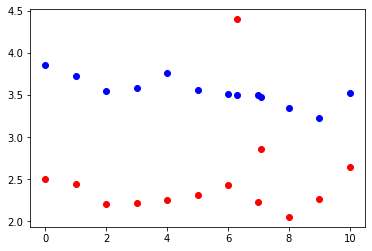

In [62]:
plt.scatter(h[h['CHINA_INFLU_ECON2'] == 0]['LADDER_NOW'], h[h['CHINA_INFLU_ECON2'] == 0]['influenceScale'], color='red')

plt.scatter(h[h['CHINA_INFLU_ECON2'] != 0]['LADDER_NOW'], h[h['CHINA_INFLU_ECON2'] != 0]['influenceScale'], color='blue')




In [65]:
model.groupby('US_MIL_ASIA')['influenceScale'].agg(['mean', 'count'])

,mean,count
US_MIL_ASIA,,
1.0,3.218679,439
2.0,2.968807,545
3.0,3.411348,423


In [56]:
model.groupby('CHINA_INFLU_ECON2')['LADDER_NOW'].plt(model.groupby('CHINA_INFLU_ECON2')['inluenceScale'].mean() )

AttributeError: 'SeriesGroupBy' object has no attribute 'plt'

### Let's figure out what is most important   
 
Reduce dimensionality by calculating feature importance and dropping results below a certain threshold    

Rerun the model utilizing the new (reduced) attributes   

Compare the differences

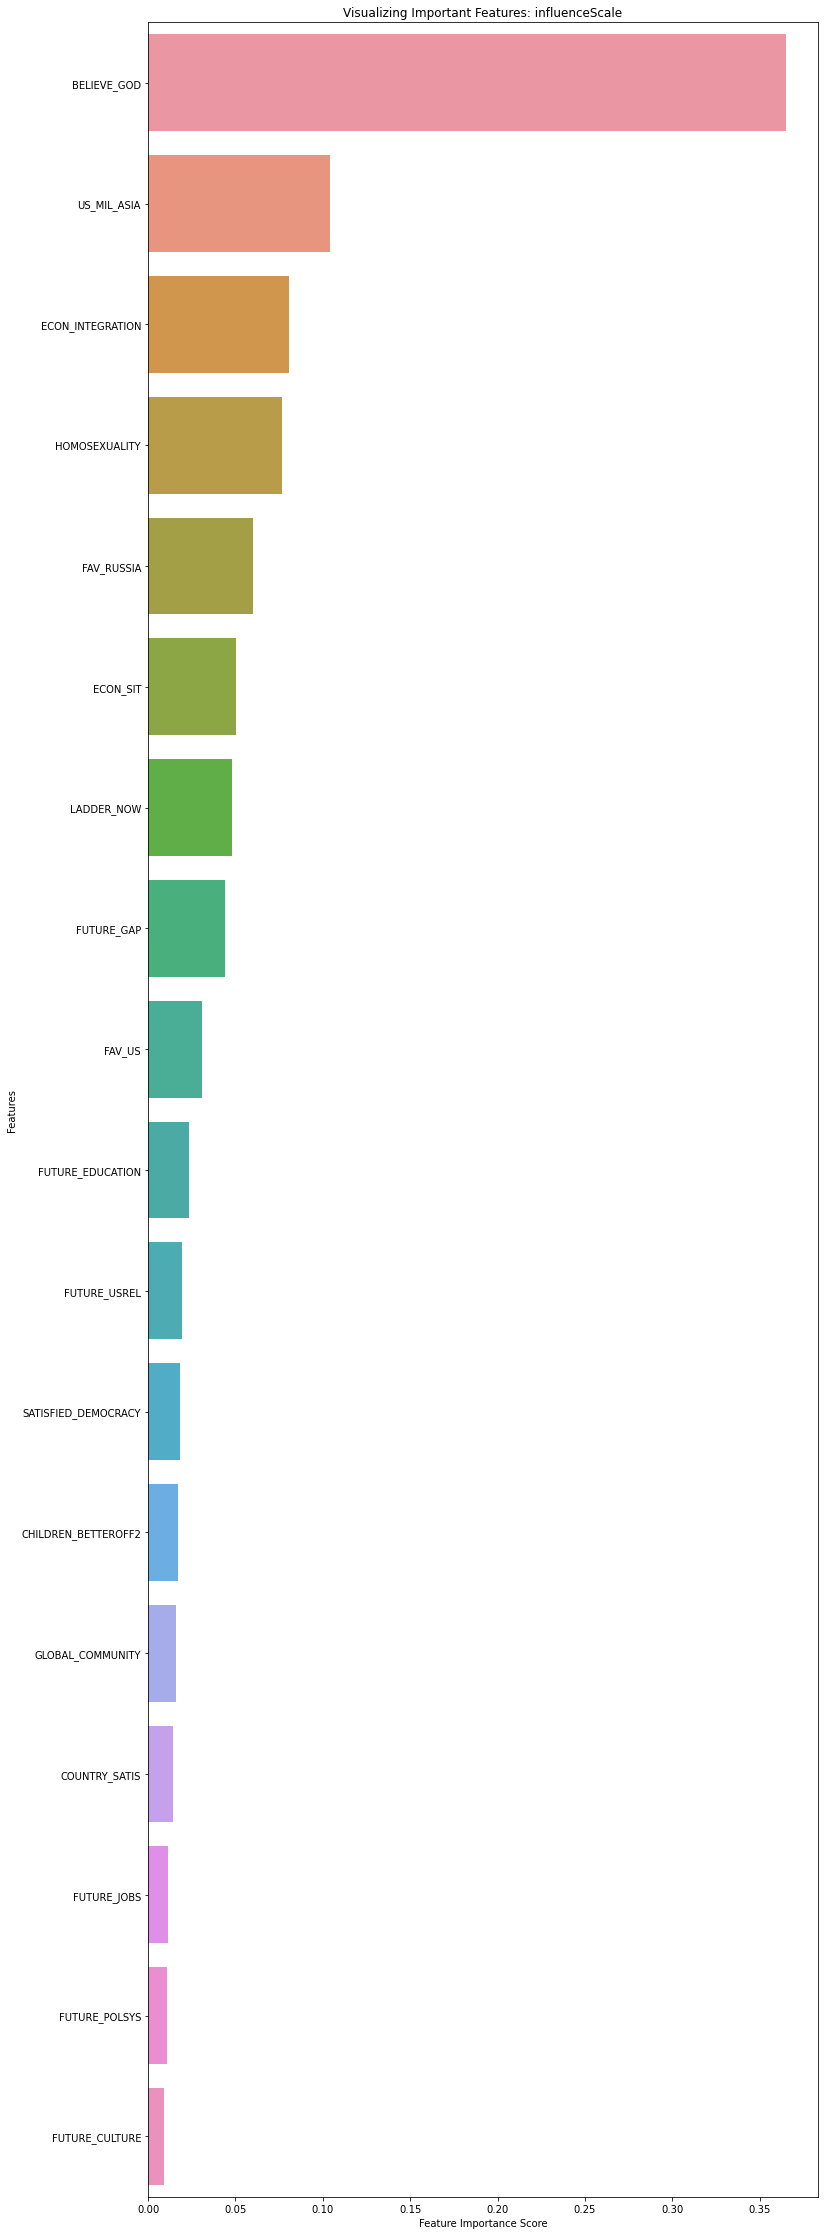

In [33]:
featureRankings = pd.DataFrame()
reducedModel, feature_imp = featureImportance(indicator= "influenceScale", x_train=xtrain, y_train=ytrain,
                               x_test=xtest, 
                               criterion='entropy', 
                               random_state=23, depth=highestDepth, prob=False, runModel=runningModel, threshold=.005)
featureRankings[["influenceScale", 'influenceScale']] = feature_imp.iloc[0:15].reset_index()

The Accuracy has increased by 0.002523460294929447 with reducing dimensionality 

[0.5168362116552322, array([[6259,   12,   20,    8,   14,  148],
       [1365,   12,   12,    3,   11,   62],
       [1097,    4,   34,   23,   22,   89],
       [ 821,    5,   15,   27,   28,  109],
       [1036,    6,   16,   36,   39,  129],
       [ 956,    1,   13,   27,   39,  183]])]


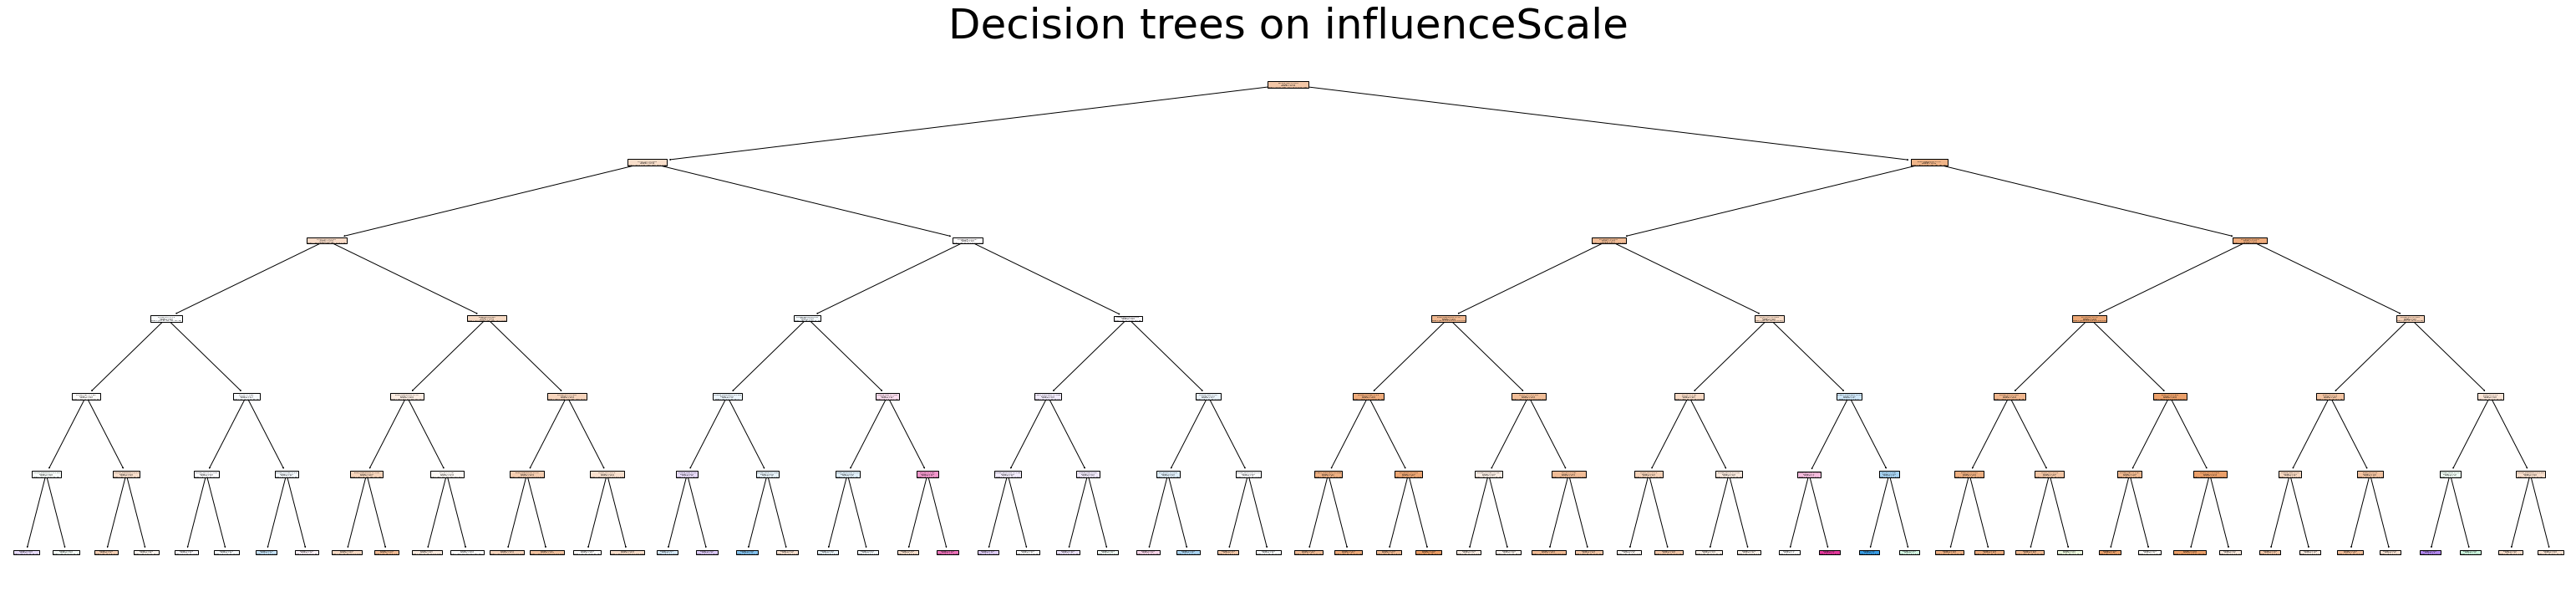

In [40]:
# data is split into training/test 
# split into train and test in a stratified manner
xtrain, xtest, ytrain, ytest = train_test_split(reducedModel, 
                                                    labels, 
                                                    test_size = 0.33)

scatter, highest, highestDepth = determine_best_depth(xtrain, ytrain, xtest, ytest, False)

# tree is built, no pruning 
predictions, tree = dtree(x_train=xtrain, y_train=ytrain,
                               x_test=xtest, 
                               criterion='entropy', 
                               random_state=23, depth=highestDepth, prob=False)
evaluationsReduced = evaluation_measures(y_true=ytest,
                                    y_pred=predictions)

print("The Accuracy has increased by " + str(evaluations[0] - evaluationsReduced[0]) + " with reducing dimensionality \n")
print(evaluationsReduced)


r = export_text(tree, feature_names=list(reducedModel.columns.values))

# print(r)
plt.figure(figsize=(55,12))
plot_tree(tree, filled=True, feature_names=list(reducedModel.columns.values))
# use fontsize= if needed 
plt.title("Decision trees on " + "influenceScale", fontsize=50)
plt.savefig("tree.png")

In [38]:
model['influenceScale'].value_counts()

0    19528
1     4399
2     3983
4     3914
5     3551
3     3051
Name: influenceScale, dtype: int64

### Results for econInfluence (none, some, alot)

influenceScale
LADDER_NOW
COUNTRY_SATIS
ECON_SIT
CHILDREN_BETTEROFF2
SATISFIED_DEMOCRACY
FAV_US
FAV_CHINA
FAV_RUSSIA
FUTURE_CULTURE
FUTURE_GAP
FUTURE_JOBS
FUTURE_EDUCATION
FUTURE_POLSYS
FUTURE_USREL
ECON_INTEGRATION
FOREIGNCOM_BUY
FOREIGNCOM_NEW
CHINA_INVEST
US_MIL_ASIA
BELIEVE_GOD
HOMOSEXUALITY
GLOBAL_COMMUNITY
ECON_TIES_CHINA
CONFID_XI
CHINA_MILITARY
CHINA_INFLU_ECON
CHINA_INFLU_ECON2
CHINA_NEW_ALLY
CHINA_NEW_THREAT
ECON_POWER_CHINA
CHINA_TIES
0.9412506900086743
2
[0.9412506900086743, array([[11936,     0],
       [  745,     0]])]


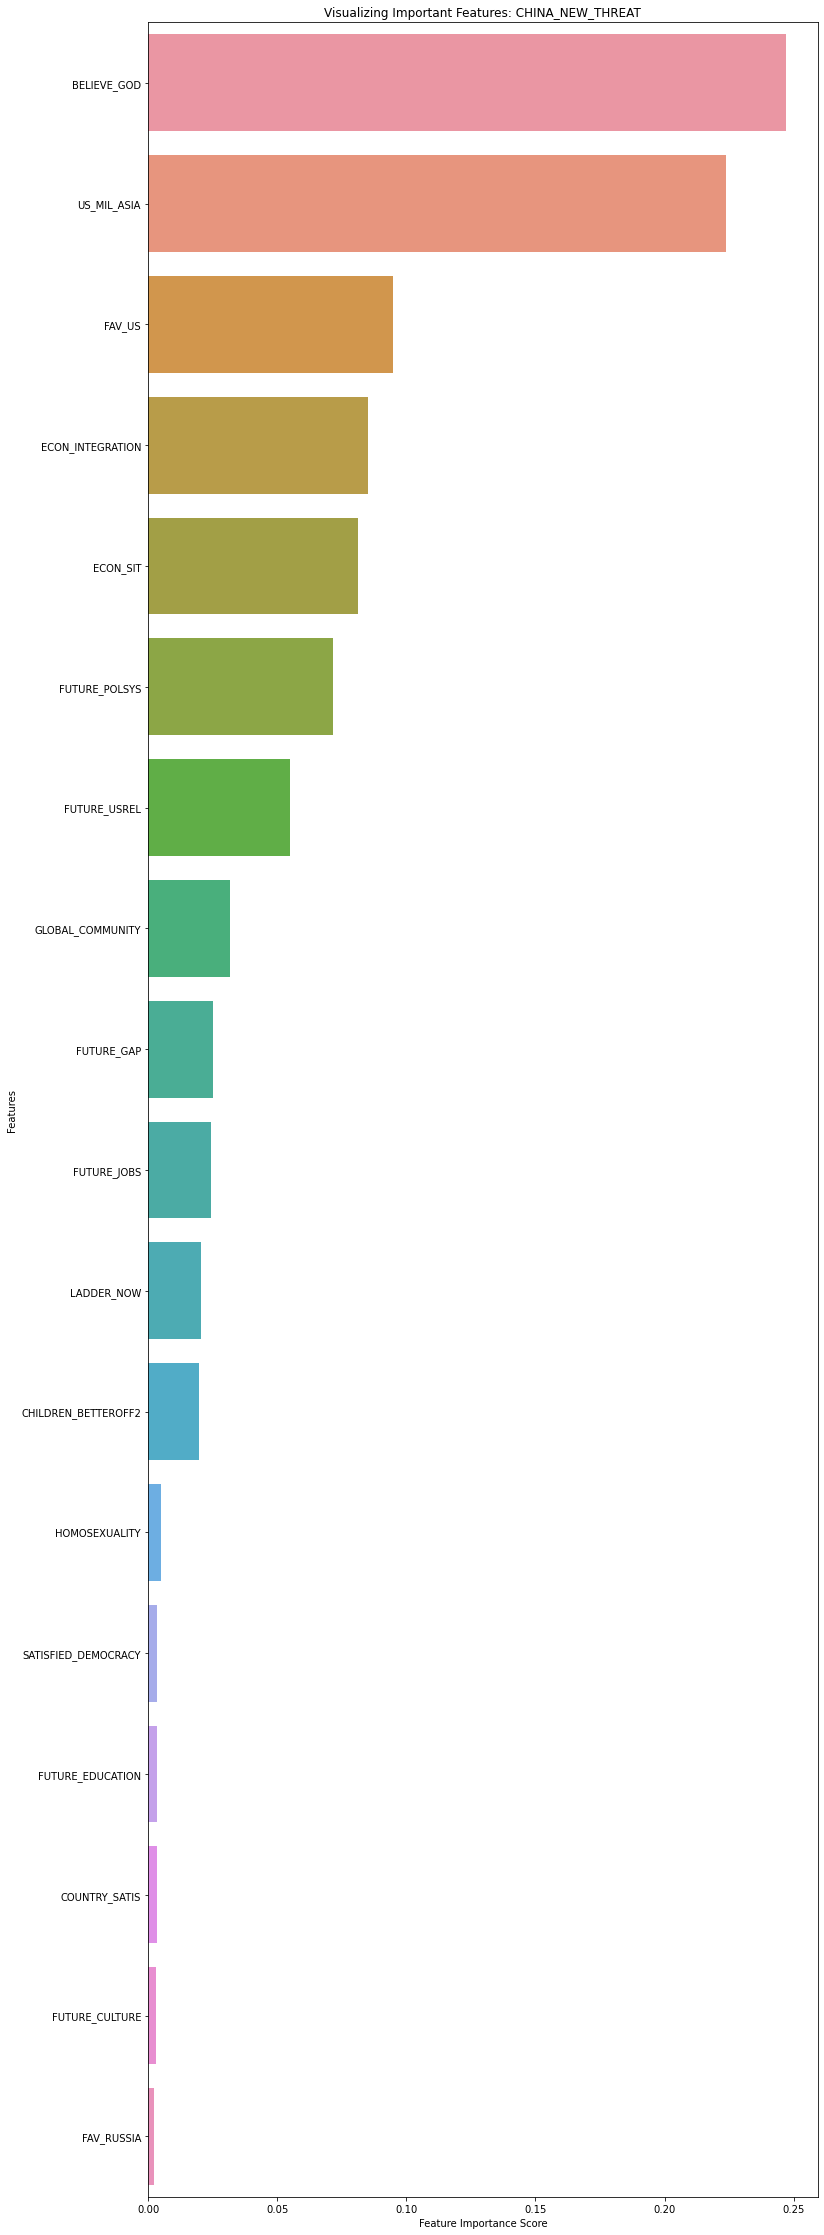

The Accuracy has increased by -0.00220802775806328 with reducing dimensionality 

[0.9434587177667376, array([[11964,     0],
       [  717,     0]])]


Text(0.5, 1.0, 'Decision trees on econInfluence')

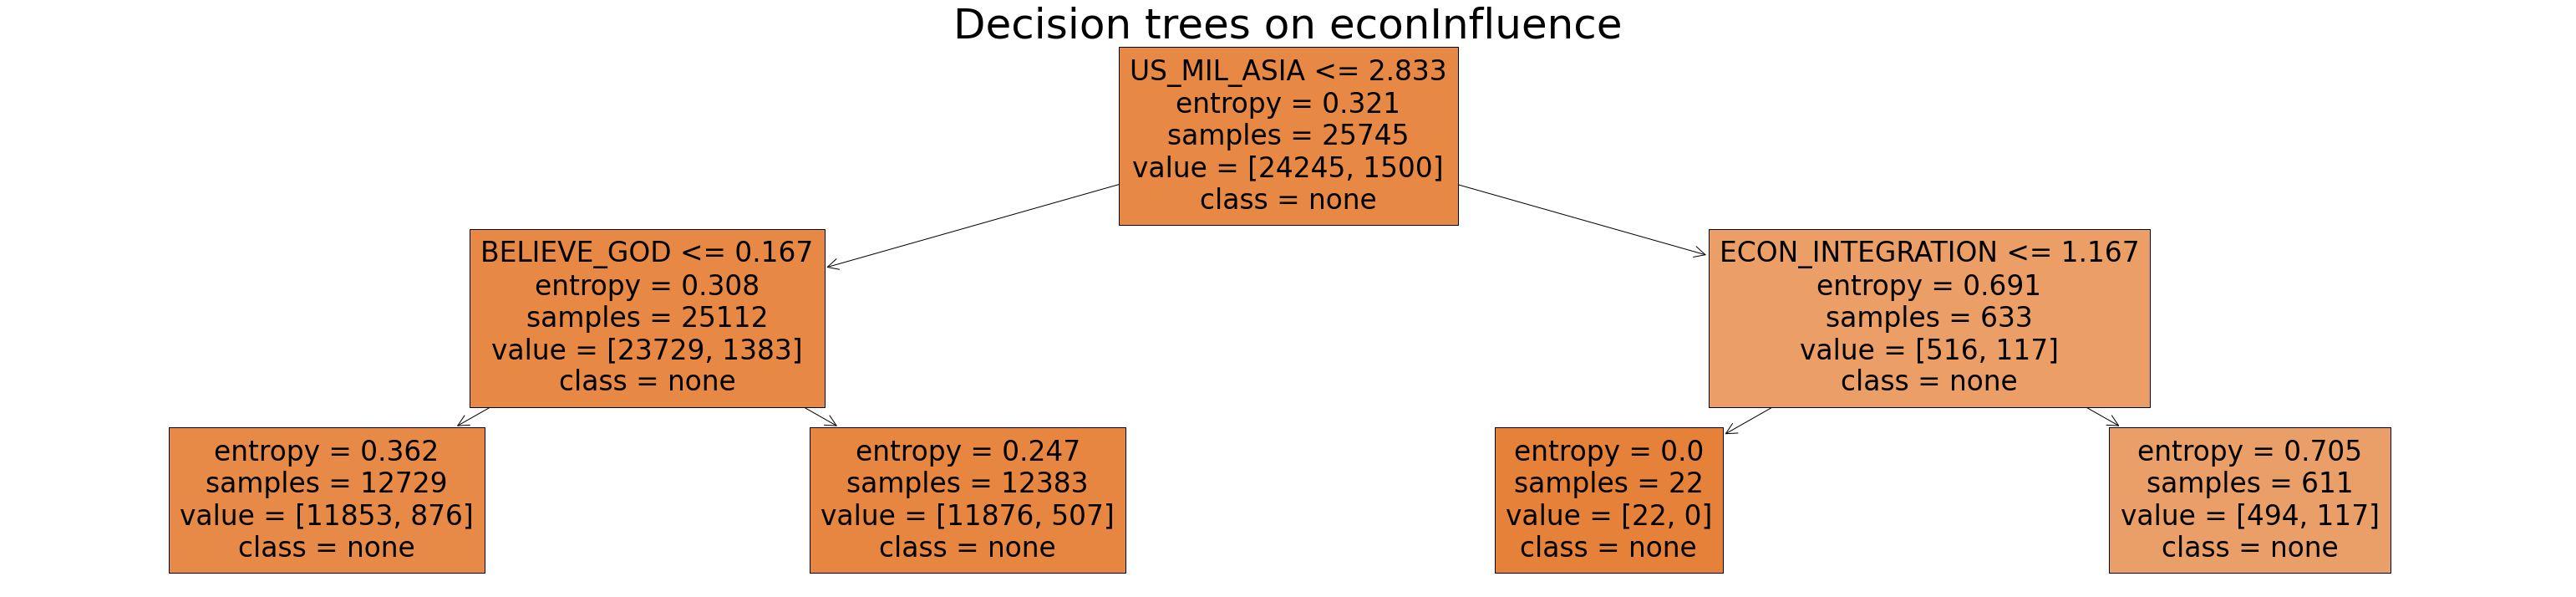

In [42]:

runningModel, labels = discretize ("CHINA_NEW_THREAT", model.copy())

# data is split into training/test 
# split into train and test in a stratified manner
xtrain, xtest, ytrain, ytest = train_test_split(runningModel, 
                                                    labels, 
                                                    test_size = 0.33)

scatter, highest, highestDepth = determine_best_depth(xtrain, ytrain, xtest, ytest, False)

print(highest)
print(highestDepth)

# tree is built, no pruning 
predictions, tree = dtree(x_train=xtrain, y_train=ytrain,
                               x_test=xtest, 
                               criterion='entropy', 
                               random_state=23, depth=highestDepth, prob=False)
evaluations = evaluation_measures(y_true=ytest,
                                    y_pred=predictions)

print(evaluations)

r = export_text(tree, feature_names=list(runningModel.columns.values))

# print(r)

reducedModel, feature_imp = featureImportance(indicator= 'CHINA_NEW_THREAT', x_train=xtrain, y_train=ytrain,
                               x_test=xtest, 
                               criterion='entropy', 
                               random_state=23, depth=highestDepth, prob=False, runModel=runningModel, threshold=.015)

featureRankings[['CHINA_NEW_THREAT', 'CHINA_NEW_THREATScores']] = feature_imp.iloc[0:15].reset_index()

# data is split into training/test 
# split into train and test in a stratified manner
xtrain, xtest, ytrain, ytest = train_test_split(reducedModel, 
                                                    labels, 
                                                    test_size = 0.33)

scatter, highest, highestDepth = determine_best_depth(xtrain, ytrain, xtest, ytest, False)

# tree is built, no pruning 
predictions, tree = dtree(x_train=xtrain, y_train=ytrain,
                               x_test=xtest, 
                               criterion='entropy', 
                               random_state=23, depth=highestDepth, prob=False)
evaluationsReduced = evaluation_measures(y_true=ytest,
                                    y_pred=predictions)

print("The Accuracy has increased by " + str(evaluations[0] - evaluationsReduced[0]) + " with reducing dimensionality \n")
print(evaluationsReduced)


r = export_text(tree, feature_names=list(reducedModel.columns.values))

# print(r)
plt.figure(figsize=(55,12))
plot_tree(tree, filled=True, feature_names=list(reducedModel.columns.values),
         class_names=[ 'none', 'some', 'a lot'])
# use fontsize= if needed 
plt.title("Decision trees on " + "econInfluence", fontsize=50)
# plt.savefig("treeeconInfluence" + ".png")

In [ ]:
variableName = 'posImageChina'

runningModel, labels = discretize (key_q81c, variableName, model.copy())

# data is split into training/test 
# split into train and test in a stratified manner
xtrain, xtest, ytrain, ytest = train_test_split(runningModel, 
                                                    labels, 
                                                    test_size = 0.33)

scatter, highest, highestDepth = determine_best_depth(xtrain, ytrain, xtest, ytest, False)

print(highest)
print(highestDepth)

# tree is built, no pruning 
predictions, tree = dtree(x_train=xtrain, y_train=ytrain,
                               x_test=xtest, 
                               criterion='entropy', 
                               random_state=23, depth=highestDepth, prob=False)
evaluations = evaluation_measures(y_true=ytest,
                                    y_pred=predictions)

print(evaluations)

r = export_text(tree, feature_names=list(runningModel.columns.values))

# print(r)

reducedModel, feature_imp = featureImportance(indicator= variableName, x_train=xtrain, y_train=ytrain,
                               x_test=xtest, 
                               criterion='entropy', 
                               random_state=23, depth=highestDepth, prob=False, runModel=runningModel, threshold=.005)

featureRankings[['posImageChina', 'posImageChinaScores']] = feature_imp.iloc[0:15].reset_index()

# data is split into training/test 
# split into train and test in a stratified manner
xtrain, xtest, ytrain, ytest = train_test_split(reducedModel, 
                                                    labels, 
                                                    test_size = 0.33)

scatter, highest, highestDepth = determine_best_depth(xtrain, ytrain, xtest, ytest, False)

# tree is built, no pruning 
predictions, tree = dtree(x_train=xtrain, y_train=ytrain,
                               x_test=xtest, 
                               criterion='entropy', 
                               random_state=23, depth=highestDepth, prob=False)
evaluationsReduced = evaluation_measures(y_true=ytest,
                                    y_pred=predictions)

print("The Accuracy has increased by " + str(evaluations[0] - evaluationsReduced[0]) + " with reducing dimensionality \n")
print(evaluationsReduced)

r = export_text(tree, feature_names=list(reducedModel.columns.values))

# print(r)
plt.figure(figsize=(55,12))
plot_tree(tree, filled=True, feature_names=list(reducedModel.columns.values),
         class_names=['international', 'laissez', 'investment', 'goods', 'softPower'])
# use fontsize= if needed 
plt.title("Decision trees on " + variableName, fontsize=50)
plt.savefig("tree" + variableName + ".png")

In [ ]:
variableName = 'negImageChina'

runningModel, labels = discretize (key_q81d, variableName, model.copy())

# data is split into training/test 
# split into train and test in a stratified manner
xtrain, xtest, ytrain, ytest = train_test_split(runningModel, 
                                                    labels, 
                                                    test_size = 0.33)

scatter, highest, highestDepth = determine_best_depth(xtrain, ytrain, xtest, ytest, False)

print(highest)
print(highestDepth)

# tree is built, no pruning 
predictions, tree = dtree(x_train=xtrain, y_train=ytrain,
                               x_test=xtest, 
                               criterion='entropy', 
                               random_state=23, depth=highestDepth, prob=False)
evaluations = evaluation_measures(y_true=ytest,
                                    y_pred=predictions)

print(evaluations)

r = export_text(tree, feature_names=list(runningModel.columns.values))

# print(r)

reducedModel, feature_imp = featureImportance(indicator= variableName, x_train=xtrain, y_train=ytrain,
                               x_test=xtest, 
                               criterion='entropy', 
                               random_state=23, depth=highestDepth, prob=False, runModel=runningModel, threshold=.005)

featureRankings[['negImageChinaInfluence', 'negImageChinaScores']] = feature_imp.iloc[0:15].reset_index()

# data is split into training/test 
# split into train and test in a stratified manner
xtrain, xtest, ytrain, ytest = train_test_split(reducedModel, 
                                                    labels, 
                                                    test_size = 0.33)

scatter, highest, highestDepth = determine_best_depth(xtrain, ytrain, xtest, ytest, False)

# tree is built, no pruning 
predictions, tree = dtree(x_train=xtrain, y_train=ytrain,
                               x_test=xtest, 
                               criterion='entropy', 
                               random_state=23, depth=highestDepth, prob=False)
evaluationsReduced = evaluation_measures(y_true=ytest,
                                    y_pred=predictions)

print("The Accuracy has increased by " + str(evaluations[0] - evaluationsReduced[0]) + " with reducing dimensionality \n")
print(evaluationsReduced)


r = export_text(tree, feature_names=list(reducedModel.columns.values))

# print(r)
plt.figure(figsize=(55,12))
plot_tree(tree, filled=True, feature_names=list(reducedModel.columns.values),
         class_names=['resources', 'corruption', 'business', 'softPower'])
# use fontsize= if needed 
plt.title("Decision trees on " + variableName, fontsize=50)
plt.savefig("tree" + variableName + ".png")

In [ ]:
featureRankings
dfi.export(featureRankings, 'featureRankings.png')
featureRankings

In [ ]:
featureRankings[['posnegInfluence', 'econInfluence']]

featureRankings.pivot_table(index=['posnegInfluence', 'econInfluence', 'posImageChina'], 
                            aggfunc='size')

np.intersect1d(featureRankings['posnegInfluence'], featureRankings['econInfluence'])

#np.intersect1d(featureRankings['posImageChina'], featureRankings['negImageChinaInfluence'])